# Unsupervised Learning Trading Strategy
- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns.

## 1. Download/Load SP500 stocks prices data.

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import xlsxwriter
import yfinance as yf
import pandas_ta as ta
import datetime as dt
import warnings

warnings.filterwarnings('ignore')

In [3]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

symbols_list.remove('VLTO')

symbols_string = " ".join(str(element) for element in symbols_list)
tickers = yf.Tickers(symbols_string)

end_date = '2024-01-04'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# tickers = Ticker(symbols_string, asynchronous=True)

# Default period = ytd, interval = 1d

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df


[*********************100%%**********************]  502 of 502 completed


Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-06 A      38.171913   40.730000   40.990002   40.049999   40.240002   
           AAL    39.401264   41.230000   41.700001   40.000000   40.049999   
           AAPL   22.919138   25.174999   25.592501   24.967501   25.139999   
           ABBV   40.230892   57.380001   57.560001   56.180000   56.369999   
           ABT    36.461636   42.560001   42.980000   42.209999   42.310001   
...                     ...         ...         ...         ...         ...   
2024-01-03 YUM   129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH   120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA  252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION   42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS   192.929993  192.929993  195.949997  192.800003  195.919998   

                      Volume  
Date                          
2016-01-06 A       2103600.0  
           AAL    12393800.0  
           AAPL  273829600.0  
           ABBV    8952700.0  
           ABT     5906000.0  
...                      ...  
2024-01-03 YUM     1483600.0  
           ZBH     2325500.0  
           ZBRA     404800.0  
           ZION    3048300.0  
           ZTS     1493000.0  

[994485 rows x 6 columns]

In [4]:
df.index.names = ['date', 'symbol']
df.columns = df.columns.str.lower()

df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171913   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401264   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919138   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.230892   57.380001   57.560001   56.180000   56.369999   
           ABT      36.461636   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  
date       symbol               
2016-01-06 A         2103600.0  
           AAL      12393800.0  
           AAPL    273829600.0  
           ABBV      8952700.0  
           ABT       5906000.0  
...                        ...  
2024-01-03 YUM       1483600.0  
           ZBH       2325500.0  
           ZBRA       404800.0  
           ZION      3048300.0  
           ZTS       1493000.0  

[994485 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

In [5]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171913   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401264   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919138   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.230892   57.380001   57.560001   56.180000   56.369999   
           ABT      36.461636   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol  
date       symbol                                 
2016-01-06 A         2103600.0         -0.000806  
           AAL      12393800.0          0.000763  
           AAPL    273829600.0         -0.002999  
           ABBV      8952700.0         -0.043655  
           ABT       5906000.0         -0.008385  
...                        ...               ...  
2024-01-03 YUM       1483600.0          0.000055  
           ZBH       2325500.0          0.000080  
           ZBRA       404800.0          0.000515  
           ZION      3048300.0          0.000349  
           ZTS       1493000.0          0.000040  

[994485 rows x 7 columns]

<Axes: xlabel='date'>

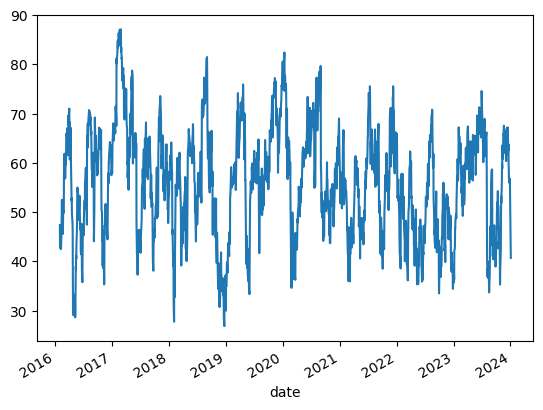

In [6]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.rsi(close=x, length = 20))

df.xs('AAPL', level=1)['rsi'].plot()

In [7]:
df = df.groupby(level='symbol').filter(lambda x: len(x) >= 20)

In [8]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [9]:
df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171913   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401264   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919138   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.230892   57.380001   57.560001   56.180000   56.369999   
           ABT      36.461636   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.043655        NaN       NaN   
           ABT       5906000.0         -0.008385        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high  
date       symbol                      
2016-01-06 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2024-01-03 YUM     4.864795  4.901488  
           ZBH     4.787581  4.819187  
           ZBRA    5.554209  5.679848  
           ZION    3.760402  3.891330  
           ZTS     5.266937  5.329454  

[994485 rows x 11 columns]

In [10]:
ta.atr(high=df['high'], low=df['low'],close=df['close'],length=14)

date        symbol
2016-01-06  A                NaN
            AAL              NaN
            AAPL             NaN
            ABBV             NaN
            ABT              NaN
                         ...    
2024-01-03  YUM        98.963353
            ZBH        92.564542
            ZBRA       96.315645
            ZION      104.483099
            ZTS       108.016449
Name: ATRr_14, Length: 994485, dtype: float64

In [11]:
def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['high'], low=stock_data['low'],close=stock_data['close'],length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [12]:
df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171913   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401264   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919138   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.230892   57.380001   57.560001   56.180000   56.369999   
           ABT      36.461636   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.043655        NaN       NaN   
           ABT       5906000.0         -0.008385        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr  
date       symbol                                
2016-01-06 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  
           ZBH     4.787581  4.819187 -1.050234  
           ZBRA    5.554209  5.679848  0.006201  
           ZION    3.760402  3.891330  0.300673  
           ZTS     5.266937  5.329454  0.420384  

[994485 rows x 12 columns]

In [13]:
def compute_macd(close):
    macd = ta.macd(close=close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171913   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401264   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919138   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.230892   57.380001   57.560001   56.180000   56.369999   
           ABT      36.461636   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.043655        NaN       NaN   
           ABT       5906000.0         -0.008385        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr      macd  
date       symbol                                          
2016-01-06 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  0.574398  
           ZBH     4.787581  4.819187 -1.050234  0.886119  
           ZBRA    5.554209  5.679848  0.006201  1.213089  
           ZION    3.760402  3.891330  0.300673  1.757465  
           ZTS     5.266937  5.329454  0.420384  1.808639  

[994485 rows x 13 columns]

In [14]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171913   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401264   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919138   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.230892   57.380001   57.560001   56.180000   56.369999   
           ABT      36.461636   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.043655        NaN       NaN   
           ABT       5906000.0         -0.008385        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       symbol                                                         
2016-01-06 A            NaN       NaN       NaN       NaN      80.298436  
           AAL          NaN       NaN       NaN       NaN     488.331388  
           AAPL         NaN       NaN       NaN       NaN    6275.938378  
           ABBV         NaN       NaN       NaN       NaN     360.175108  
           ABT          NaN       NaN       NaN       NaN     215.342420  
...                     ...       ...       ...       ...            ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  0.574398     191.532769  
           ZBH     4.787581  4.819187 -1.050234  0.886119     280.152988  
           ZBRA    5.554209  5.679848  0.006201  1.213089     102.220098  
           ZION    3.760402  3.891330  0.300673  1.757465     128.028600  
           ZTS     5.266937  5.329454  0.420384  1.808639     288.044479  

[994485 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [15]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
last_cols

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [16]:
data=pd.concat([df.unstack('symbol')['dollar_volume'].resample('M').mean().stack('symbol').to_frame('dollar_volume'),
         df.unstack()[last_cols].resample('M').last().stack('symbol')], axis=1).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       symbol                                                           
2016-02-29 A           91.918047   35.004200         -0.001914  48.056796   
           AAL        338.977820   39.288376         -0.000319  56.535091   
           AAPL      3548.073617   22.125887         -0.003013  49.871974   
           ABBV       353.627752   38.690910         -0.051766  47.996240   
           ABT        244.683689   33.398460         -0.009964  47.314227   
...                          ...         ...               ...        ...   
2024-01-31 YUM        191.590513  129.100006          0.000055  54.360388   
           ZBH        206.076237  120.470001          0.000080  63.340087   
           ZBRA       111.794122  252.520004          0.000515  52.714502   
           ZION       113.819668   42.000000          0.000349  56.397718   
           ZTS        305.435701  192.929993          0.000040  58.881491   

                     bb_low    bb_mid   bb_high       atr      macd  
date       symbol                                                    
2016-02-29 A       3.522493  3.571307  3.620122 -0.932254 -0.223694  
           AAL     3.547833  3.638646  3.729458  0.974628  0.507461  
           AAPL    3.106253  3.130723  3.155194 -1.020407 -0.318754  
           ABBV    3.629341  3.677365  3.725388 -0.472983 -0.317716  
           ABT     3.479070  3.522661  3.566251 -0.794542 -0.387866  
...                     ...       ...       ...       ...       ...  
2024-01-31 YUM     4.828101  4.864795  4.901488 -0.079818  0.574398  
           ZBH     4.755974  4.787581  4.819187 -1.050234  0.886119  
           ZBRA    5.428569  5.554209  5.679848  0.006201  1.213089  
           ZION    3.629474  3.760402  3.891330  0.300673  1.757465  
           ZTS     5.204421  5.266937  5.329454  0.420384  1.808639  

[47453 rows x 9 columns]

Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [17]:
data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('symbol').rolling(5*12, min_periods=12).mean().stack()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       symbol                                                           
2016-02-29 A                 NaN   35.004200         -0.001914  48.056796   
           AAL               NaN   39.288376         -0.000319  56.535091   
           AAPL              NaN   22.125887         -0.003013  49.871974   
           ABBV              NaN   38.690910         -0.051766  47.996240   
           ABT               NaN   33.398460         -0.009964  47.314227   
...                          ...         ...               ...        ...   
2024-01-31 YUM        187.226837  129.100006          0.000055  54.360388   
           ZBH        174.610138  120.470001          0.000080  63.340087   
           ZBRA       125.739346  252.520004          0.000515  52.714502   
           ZION        87.558095   42.000000          0.000349  56.397718   
           ZTS        305.388801  192.929993          0.000040  58.881491   

                     bb_low    bb_mid   bb_high       atr      macd  
date       symbol                                                    
2016-02-29 A       3.522493  3.571307  3.620122 -0.932254 -0.223694  
           AAL     3.547833  3.638646  3.729458  0.974628  0.507461  
           AAPL    3.106253  3.130723  3.155194 -1.020407 -0.318754  
           ABBV    3.629341  3.677365  3.725388 -0.472983 -0.317716  
           ABT     3.479070  3.522661  3.566251 -0.794542 -0.387866  
...                     ...       ...       ...       ...       ...  
2024-01-31 YUM     4.828101  4.864795  4.901488 -0.079818  0.574398  
           ZBH     4.755974  4.787581  4.819187 -1.050234  0.886119  
           ZBRA    5.428569  5.554209  5.679848  0.006201  1.213089  
           ZION    3.629474  3.760402  3.891330  0.300673  1.757465  
           ZTS     5.204421  5.266937  5.329454  0.420384  1.808639  

[47453 rows x 9 columns]

In [18]:
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       symbol                                                           
2016-02-29 A                 NaN   35.004200         -0.001914  48.056796   
           AAL               NaN   39.288376         -0.000319  56.535091   
           AAPL              NaN   22.125887         -0.003013  49.871974   
           ABBV              NaN   38.690910         -0.051766  47.996240   
           ABT               NaN   33.398460         -0.009964  47.314227   
...                          ...         ...               ...        ...   
2024-01-31 YUM        187.226837  129.100006          0.000055  54.360388   
           ZBH        174.610138  120.470001          0.000080  63.340087   
           ZBRA       125.739346  252.520004          0.000515  52.714502   
           ZION        87.558095   42.000000          0.000349  56.397718   
           ZTS        305.388801  192.929993          0.000040  58.881491   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       symbol                                                     
2016-02-29 A       3.522493  3.571307  3.620122 -0.932254 -0.223694   
           AAL     3.547833  3.638646  3.729458  0.974628  0.507461   
           AAPL    3.106253  3.130723  3.155194 -1.020407 -0.318754   
           ABBV    3.629341  3.677365  3.725388 -0.472983 -0.317716   
           ABT     3.479070  3.522661  3.566251 -0.794542 -0.387866   
...                     ...       ...       ...       ...       ...   
2024-01-31 YUM     4.828101  4.864795  4.901488 -0.079818  0.574398   
           ZBH     4.755974  4.787581  4.819187 -1.050234  0.886119   
           ZBRA    5.428569  5.554209  5.679848  0.006201  1.213089   
           ZION    3.629474  3.760402  3.891330  0.300673  1.757465   
           ZTS     5.204421  5.266937  5.329454  0.420384  1.808639   

                   dollar_vol_rank  
date       symbol                   
2016-02-29 A                   NaN  
           AAL                 NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
...                            ...  
2024-01-31 YUM               260.0  
           ZBH               278.0  
           ZBRA              357.0  
           ZION              449.0  
           ZTS               155.0  

[47453 rows x 10 columns]

In [19]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       symbol                                                      
2017-01-31 AAL      42.760254         -0.000522  42.277627  3.789144   
           AAPL     28.233547         -0.001885  67.547751  3.332440   
           ABBV     44.951492         -0.031911  49.245604  3.805577   
           ABT      36.922539         -0.003303  66.810992  3.572445   
           ACN     102.222733         -0.004494  41.080189  4.637933   
...                       ...               ...        ...       ...   
2024-01-31 VRTX    410.709991          0.000113  67.267742  5.842299   
           VZ       38.510586         -0.000152  66.850151  3.612566   
           WFC      48.680000          0.000098  63.184585  3.816344   
           WMT     159.300003          0.000033  55.532537  5.015848   
           XOM     103.220001          0.000149  51.511383  4.593886   

                     bb_mid   bb_high       atr      macd  
date       symbol                                          
2017-01-31 AAL     3.840245  3.891346  1.300756 -0.165771  
           AAPL    3.360948  3.389455 -1.193132 -0.108725  
           ABBV    3.836800  3.868023 -1.207836 -0.323847  
           ABT     3.605747  3.639048 -1.169106  0.202854  
           ACN     4.652908  4.667882 -1.023193 -0.451099  
...                     ...       ...       ...       ...  
2024-01-31 VRTX    5.968725  6.095150  1.055460  3.141795  
           VZ      3.642662  3.672758 -0.907484  0.827692  
           WFC     3.896063  3.975782 -0.702193  1.652083  
           WMT     5.048842  5.081837 -0.022442  0.067748  
           XOM     4.622754  4.651621  0.220312 -0.402836  

[12665 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [20]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    
    lags = [1,2,3,6,9,12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                      upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       symbol                                                      
2018-01-31 AAL      52.943859          0.000502  53.332142  3.908840   
           AAPL     39.581047         -0.001000  40.100801  3.700759   
           ABBV     85.312187         -0.035857  62.305733  4.262648   
           ABT      56.127316         -0.004576  69.274855  3.951524   
           ACN     147.171112         -0.002706  63.135444  4.968583   
...                       ...               ...        ...       ...   
2024-01-31 VRTX    410.709991          0.000113  67.267742  5.842299   
           VZ       38.510586         -0.000152  66.850151  3.612566   
           WFC      48.680000          0.000098  63.184585  3.816344   
           WMT     159.300003          0.000033  55.532537  5.015848   
           XOM     103.220001          0.000149  51.511383  4.593886   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       symbol                                                      
2018-01-31 AAL     3.999106  4.089372  1.281007  0.616058   0.044013   
           AAPL    3.741176  3.781592 -0.962020 -0.415350  -0.010636   
           ABBV    4.394630  4.526612  1.476512  2.085246   0.168700   
           ABT     4.010345  4.069166 -0.696952  0.971870   0.094397   
           ACN     4.992040  5.015497 -0.985922  0.291801   0.049709   
...                     ...       ...       ...       ...        ...   
2024-01-31 VRTX    5.968725  6.095150  1.055460  3.141795   0.009388   
           VZ      3.642662  3.672758 -0.907484  0.827692   0.038727   
           WFC     3.896063  3.975782 -0.702193  1.652083  -0.010971   
           WMT     5.048842  5.081837 -0.022442  0.067748   0.010466   
           XOM     4.622754  4.651621  0.220312 -0.402836   0.032406   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       symbol                                                          
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961  
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079892   0.077893   0.081654   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.041085    0.035516  
           ACN      0.041987   0.041220   0.039209   0.032852    0.030836  
...                      ...        ...        ...        ...         ...  
2024-01-31 VRTX     0.075895   0.042873   0.025878   0.020972    0.020195  
           VZ       0.010769   0.036863   0.027037   0.005272   -0.000370  
           WFC      0.044856   0.072877   0.011705   0.025556    0.005742  
           WMT      0.013404  -0.007229   0.000625   0.007221    0.009799  
           XOM      0.002333  -0.005338  -0.003484  -0.012235   -0.006913  

[10489 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

- We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [21]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2023-07-31,0.0321,0.0286,0.0411,-0.0057,0.0057
2023-08-31,-0.0239,-0.0365,-0.0106,0.0343,-0.0237
2023-09-30,-0.0524,-0.0180,0.0152,0.0186,-0.0083


In [22]:
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       symbol                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094397
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10197 rows x 6 columns]

In [23]:
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,-0.010636
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,0.068185
2018-03-31,-0.0235,0.0359,-0.0021,-0.0046,0.0001,-0.058051
2018-04-30,0.0028,0.0093,0.0054,-0.0242,0.0130,-0.015020
2018-05-31,0.0265,0.0473,-0.0320,-0.0204,-0.0150,0.135124


In [24]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,0.110708
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,-0.008415
2018-03-31,-0.0235,0.0359,-0.0021,-0.0046,0.0001,-0.026661
2018-04-30,0.0028,0.0093,0.0054,-0.0242,0.0130,0.024652
2018-05-31,0.0265,0.0473,-0.0320,-0.0204,-0.0150,0.061467


Fiter out stocks with less than 10 months of data

In [25]:
obs = factor_data.groupby(level=1).size()

valid_stocks = obs[obs >= 10]

factor_data = factor_data[factor_data.index.get_level_values('symbol').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       symbol                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094397
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10146 rows x 6 columns]

Calculate Rolling Factor Betas

In [26]:
betas = factor_data.groupby(level=1, 
                    group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                                                 exog=sm.add_constant(x.drop('return_1m', axis=1)), 
                                                                 window=min(24, x.shape[0]),
                                                                 min_nobs=len(x.columns)+1).fit().params.drop('const', axis=1))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       symbol                                                  
2018-01-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376235 -0.326701 -0.444955  0.318725  0.869058
           VZ      0.444390 -0.662954  0.517142  0.210200 -0.205916
           WFC     1.037896  0.401002  2.011853 -0.363960 -1.477538
           WMT     0.497263  0.081984 -0.730992  0.577485  0.752980
           XOM     0.722439 -0.211054  1.202663  0.229126  0.171950

[10146 rows x 5 columns]

In [27]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']
data = data.join(betas.groupby('symbol').shift())
data.loc[:, factors] = data.groupby('symbol', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))


In [28]:
data = data.dropna()
data = data.drop('adj close', axis=1)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10282 entries, (Timestamp('2018-01-31 00:00:00'), 'AAL') to (Timestamp('2024-01-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10282 non-null  float64
 1   rsi               10282 non-null  float64
 2   bb_low            10282 non-null  float64
 3   bb_mid            10282 non-null  float64
 4   bb_high           10282 non-null  float64
 5   atr               10282 non-null  float64
 6   macd              10282 non-null  float64
 7   return_1m         10282 non-null  float64
 8   return_2m         10282 non-null  float64
 9   return_3m         10282 non-null  float64
 10  return_6m         10282 non-null  float64
 11  return_9m         10282 non-null  float64
 12  return_12m        10282 non-null  float64
 13  Mkt-RF            10282 non-null  float64
 14  SMB               10282 non-null  float64
 15  HML        

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering

- You may want to initialize predefined centroids for each cluster based on your research.

- For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

- Then we will pre-define our centroids for each cluster.

In [30]:
target_rsi_values = [30, 45, 55, 70]
init_centroids = np.zeros((len(target_rsi_values), 18))
init_centroids[:, 1] = target_rsi_values
init_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [31]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, 
                           random_state=0,
                           init=init_centroids).fit(df).labels_
    return df

In [32]:
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       symbol                                                              
2018-01-31 AAL             0.000502  53.332142  3.908840  3.999106  4.089372   
           AAPL           -0.001000  40.100801  3.700759  3.741176  3.781592   
           ABBV           -0.035857  62.305733  4.262648  4.394630  4.526612   
           ABT            -0.004576  69.274855  3.951524  4.010345  4.069166   
           ACN            -0.002706  63.135444  4.968583  4.992040  5.015497   
...                             ...        ...       ...       ...       ...   
2024-01-31 VRTX            0.000113  67.267742  5.842299  5.968725  6.095150   
           VZ             -0.000152  66.850151  3.612566  3.642662  3.672758   
           WFC             0.000098  63.184585  3.816344  3.896063  3.975782   
           WMT             0.000033  55.532537  5.015848  5.048842  5.081837   
           XOM             0.000149  51.511383  4.593886  4.622754  4.651621   

                        atr      macd  return_1m  return_2m  return_3m  \
date       symbol                                                        
2018-01-31 AAL     1.281007  0.616058   0.044013   0.037235   0.051541   
           AAPL   -0.962020 -0.415350  -0.010636  -0.012944  -0.001992   
           ABBV    1.476512  2.085246   0.168700   0.079892   0.077893   
           ABT    -0.696952  0.971870   0.094397   0.052610   0.048209   
           ACN    -0.985922  0.291801   0.049709   0.041987   0.041220   
...                     ...       ...        ...        ...        ...   
2024-01-31 VRTX    1.055460  3.141795   0.009388   0.075895   0.042873   
           VZ     -0.907484  0.827692   0.038727   0.010769   0.036863   
           WFC    -0.702193  1.652083  -0.010971   0.044856   0.072877   
           WMT    -0.022442  0.067748   0.010466   0.013404  -0.007229   
           XOM     0.220312 -0.402836   0.032406   0.002333  -0.005338   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       symbol                                                         
2018-01-31 AAL      0.013139   0.028045    0.017961  1.249736  1.364595   
           AAPL     0.021212   0.018481    0.028553  1.309701 -0.322261   
           ABBV     0.081654   0.063580    0.054846  0.471506  0.471106   
           ABT      0.041483   0.041085    0.035516  0.816741 -0.161601   
           ACN      0.039209   0.032852    0.030836  1.214364 -0.164227   
...                      ...        ...         ...       ...       ...   
2024-01-31 VRTX     0.025878   0.020972    0.020195  0.524475  0.002246   
           VZ       0.027037   0.005272   -0.000370  0.488872 -0.360812   
           WFC      0.011705   0.025556    0.005742  1.075629 -0.094370   
           WMT      0.000625   0.007221    0.009799  0.610658 -0.446031   
           XOM     -0.003484  -0.012235   -0.006913  1.138573  0.273421   

                        HML       RMW       CMA  cluster  
date       symbol                                         
2018-01-31 AAL     0.549848  0.308941  0.675167        1  
           AAPL   -0.616118  0.569083  0.568927        0  
           ABBV   -0.092783  0.370381  0.262610        2  
           ABT    -0.518418  0.287252  0.988155        3  
           ACN    -0.309528  0.294605  0.177386        2  
...                     ...       ...       ...      ...  
2024-01-31 VRTX   -0.905770  0.132113  0.859881        3  
           VZ      0.085450  0.292010  0.474456        3  
           WFC     1.437468 -0.731784 -0.615394        0  
           WMT    -0.313550  0.315892  0.700379        2  
           XOM     0.674840 -0.489299  0.648737        2  

[10282 rows x 19 columns]

In [33]:
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color='red', label='cluster0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color='green', label='cluster1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color='blue', label='cluster2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color='black', label='cluster3')

    plt.legend()
    plt.show()
    return

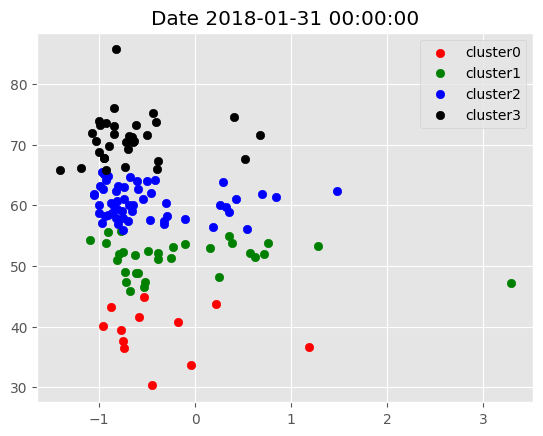

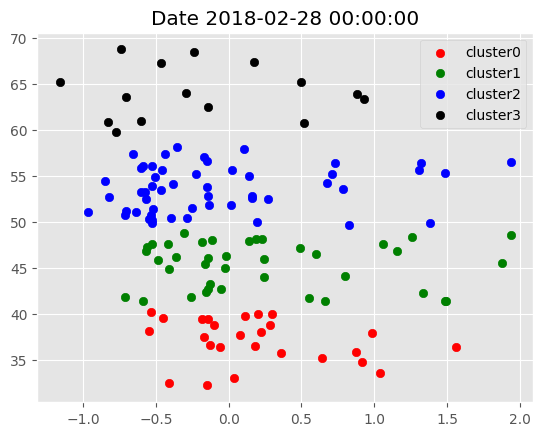

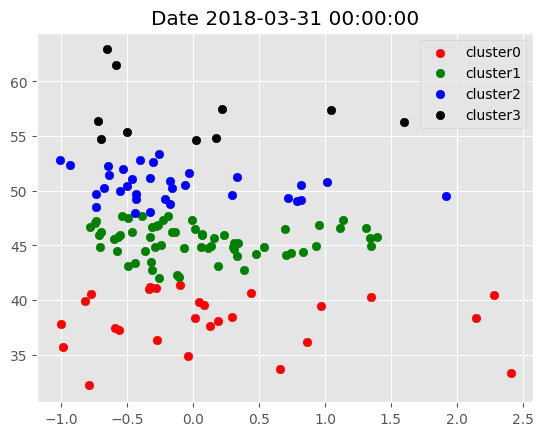

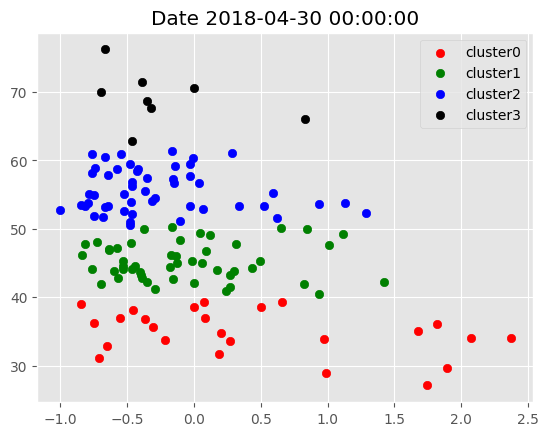

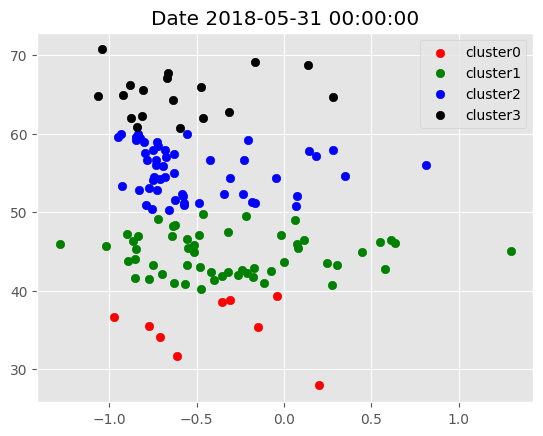

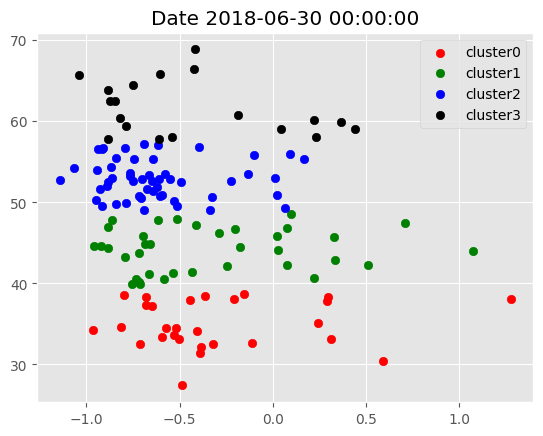

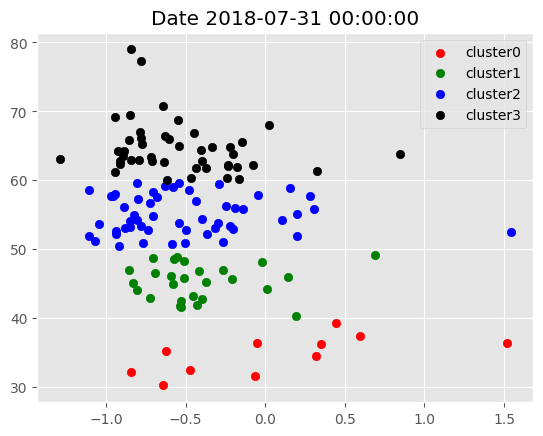

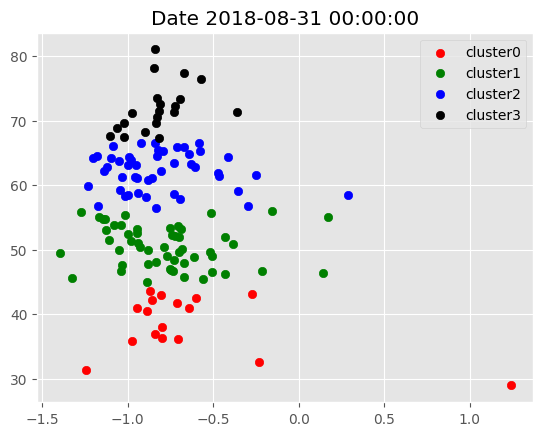

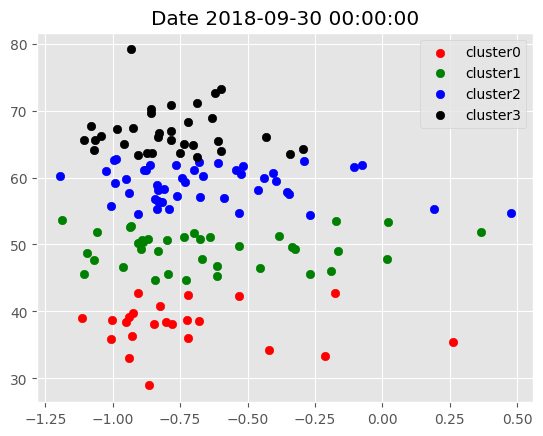

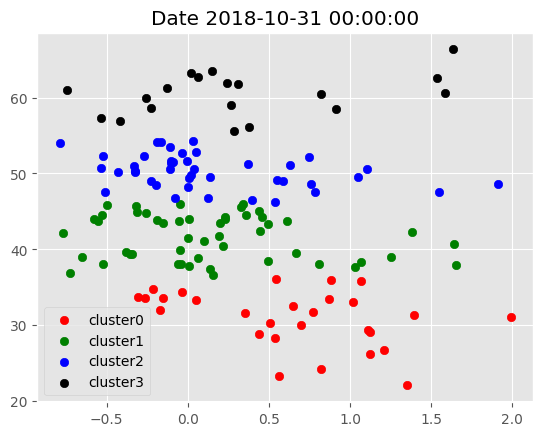

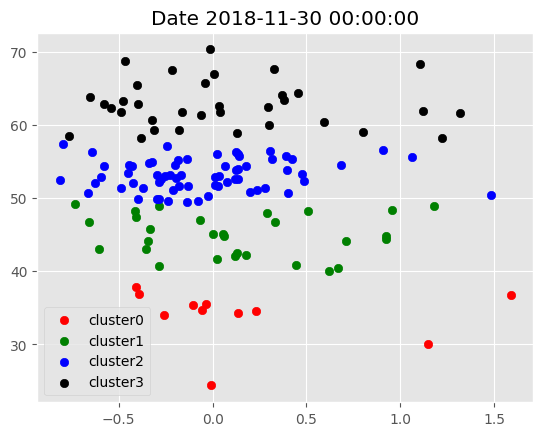

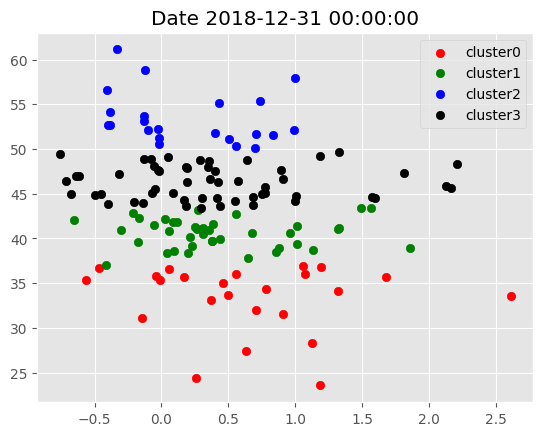

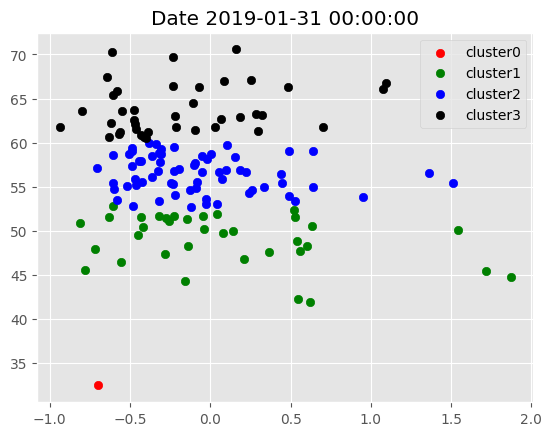

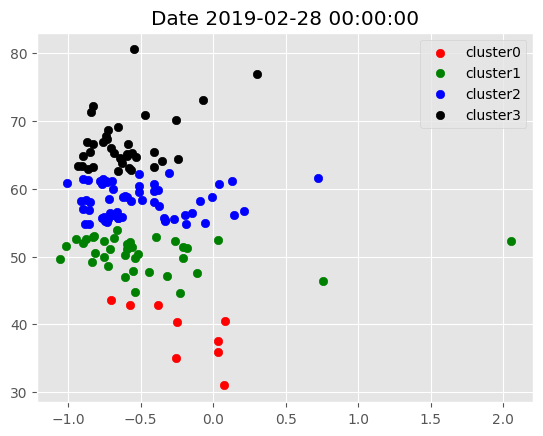

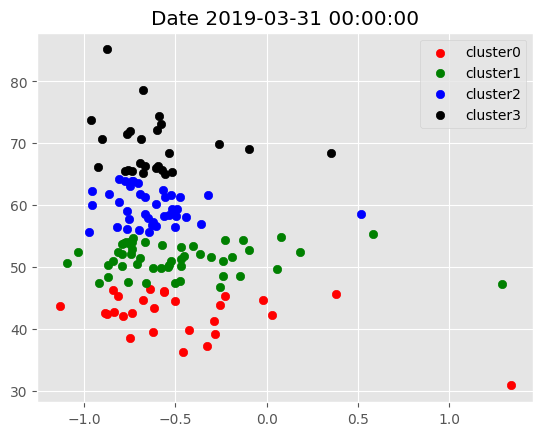

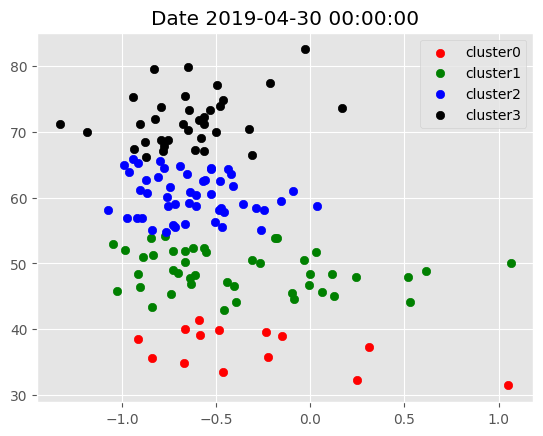

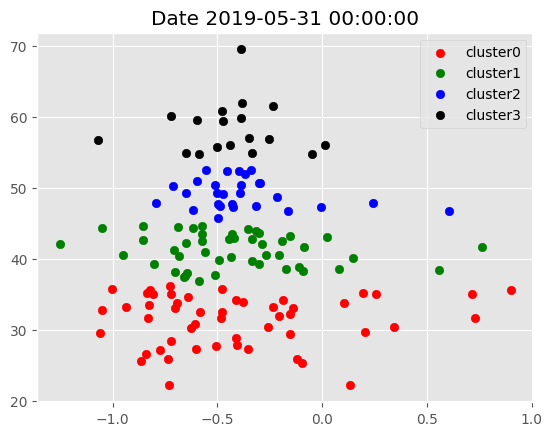

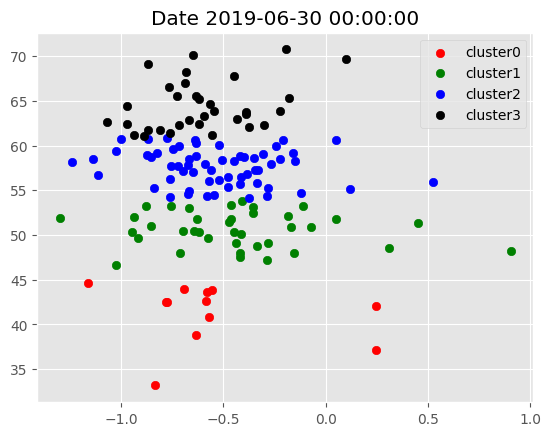

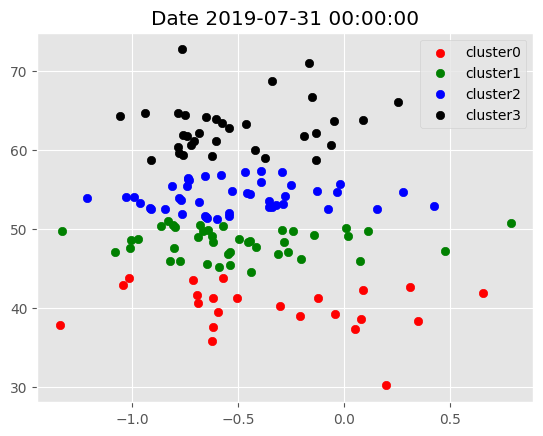

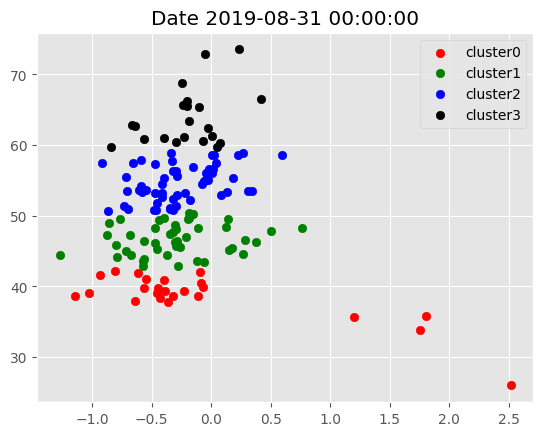

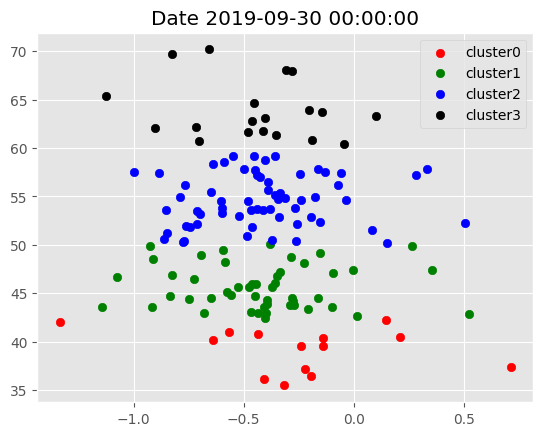

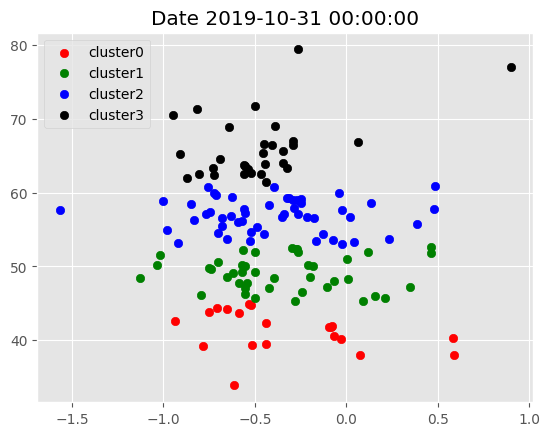

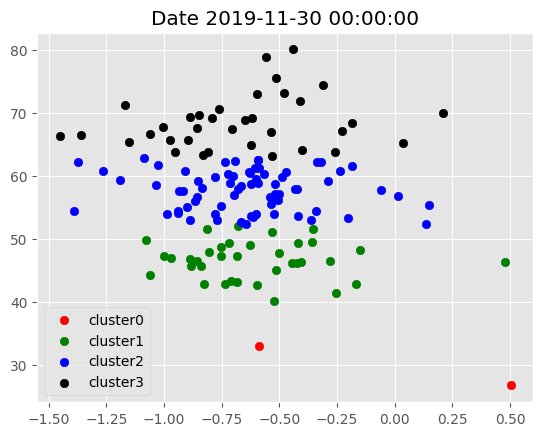

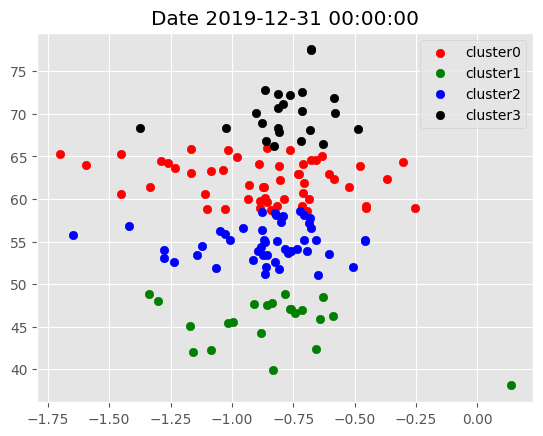

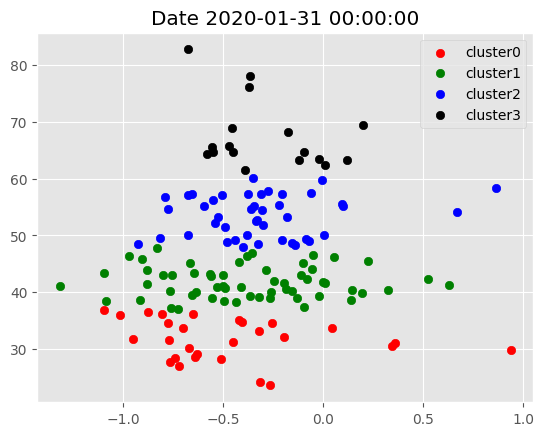

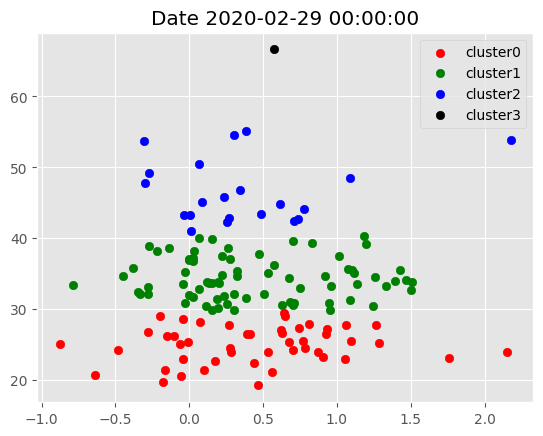

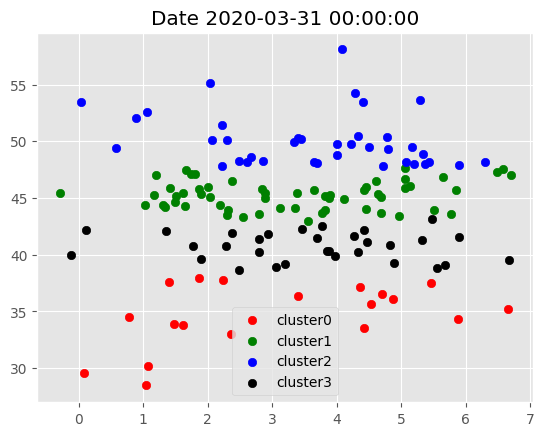

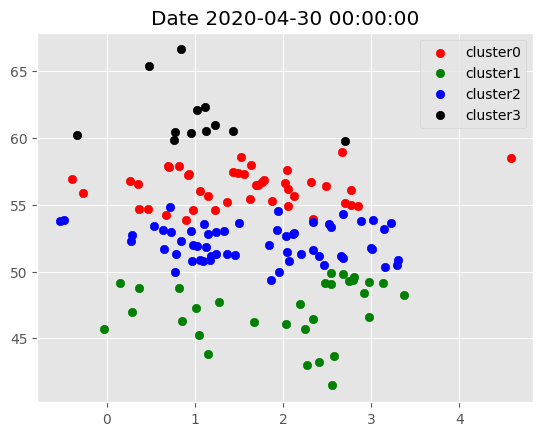

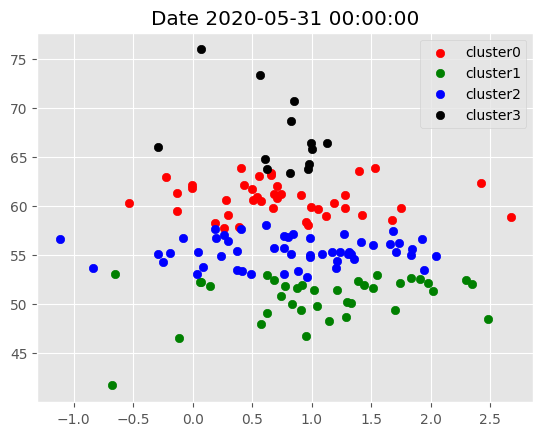

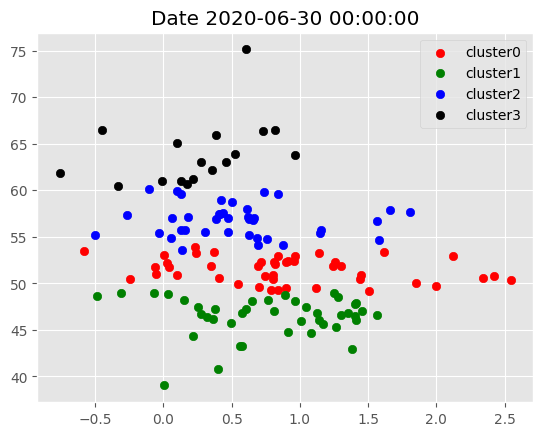

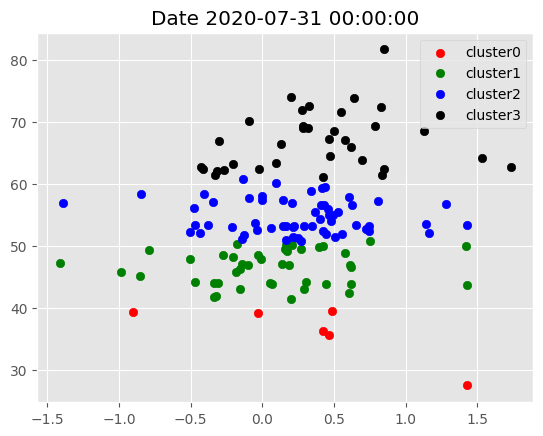

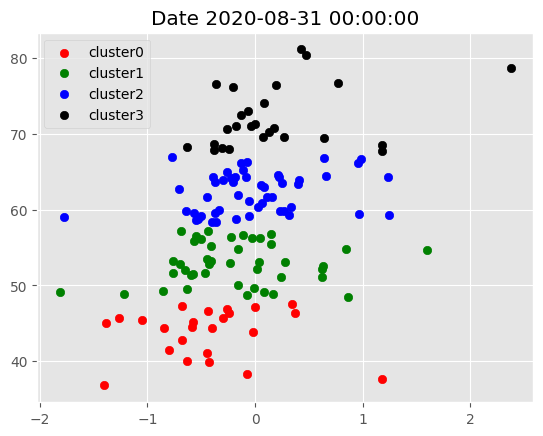

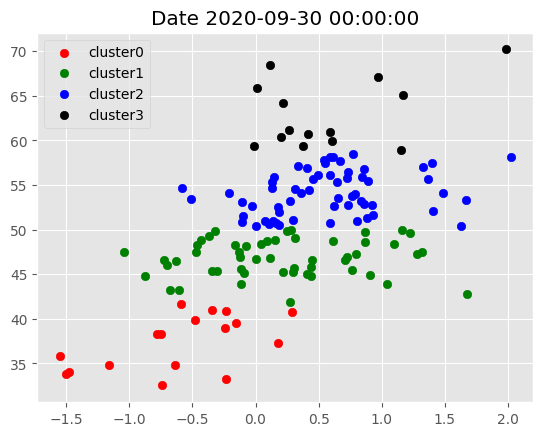

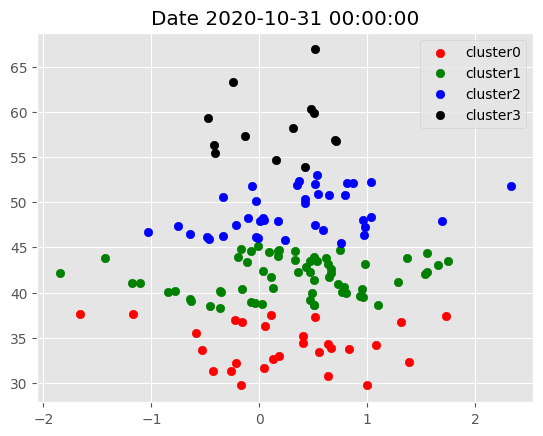

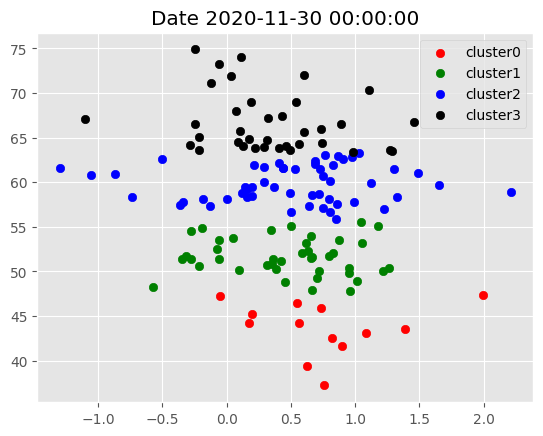

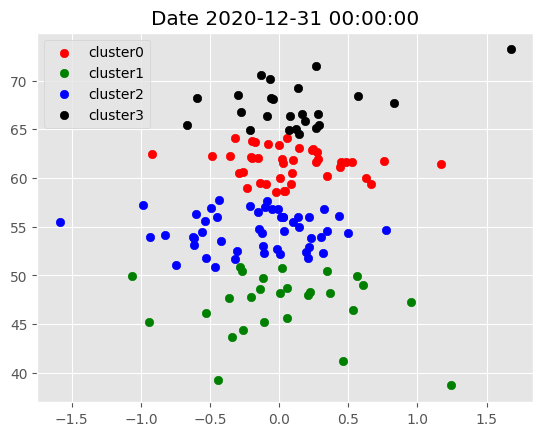

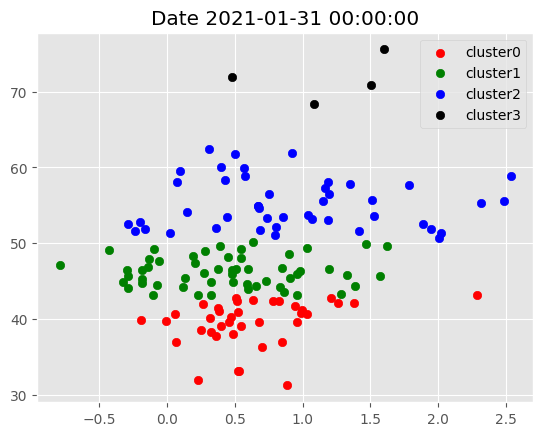

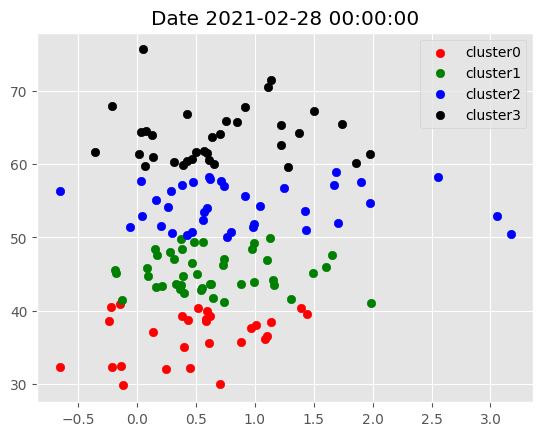

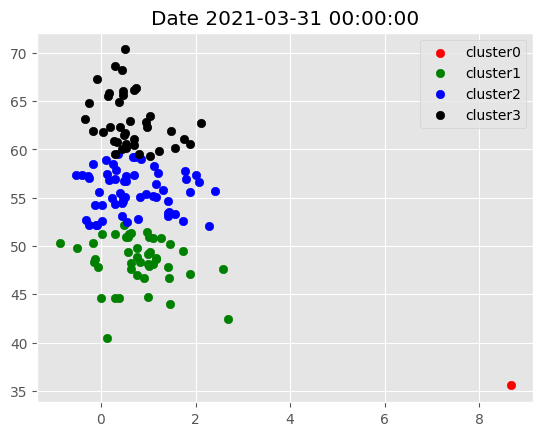

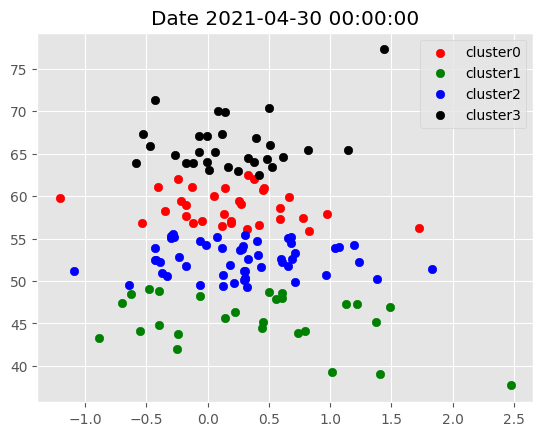

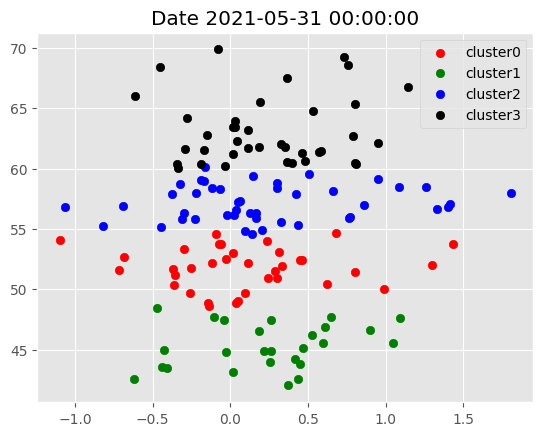

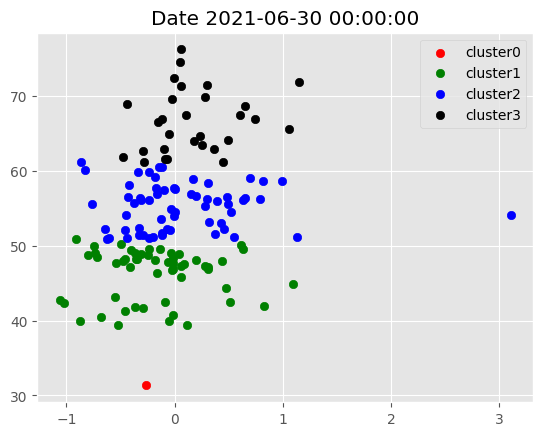

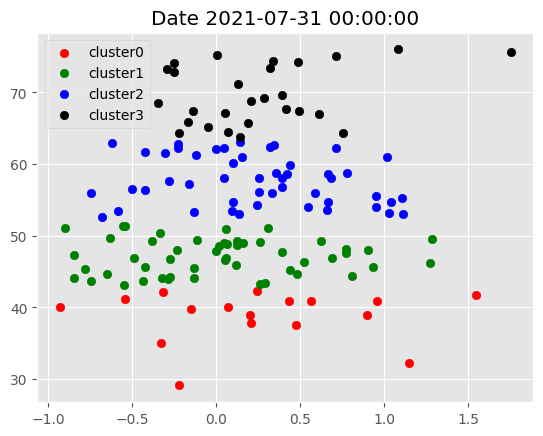

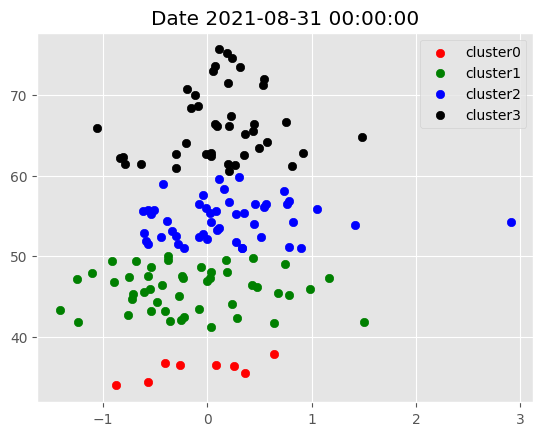

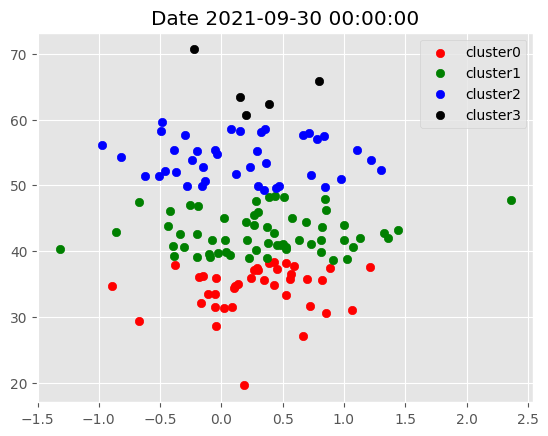

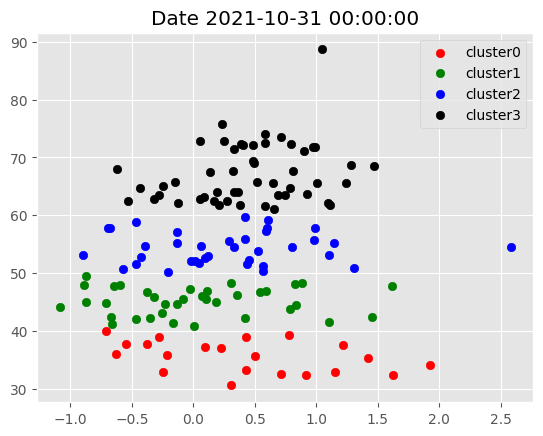

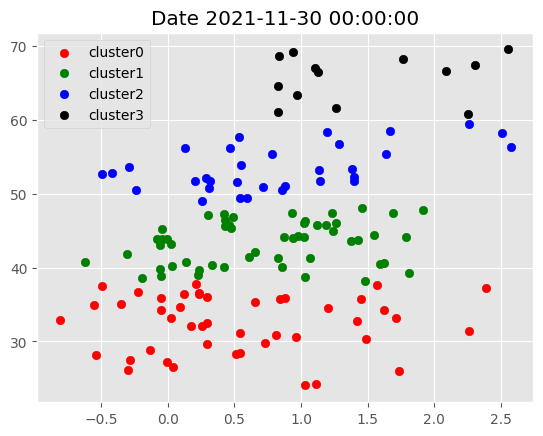

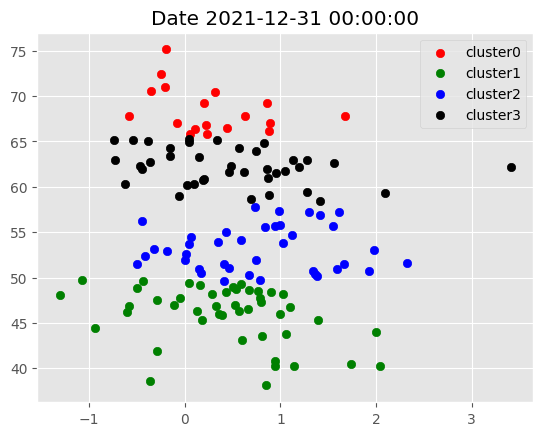

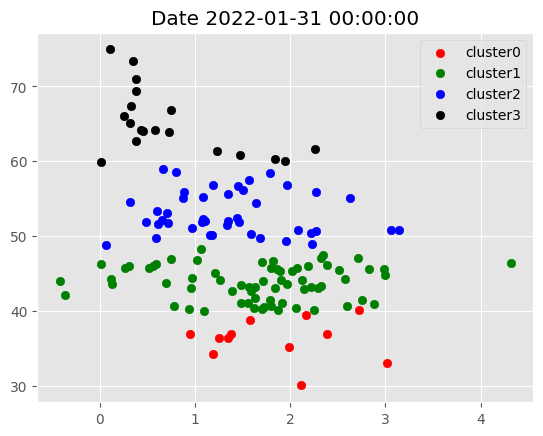

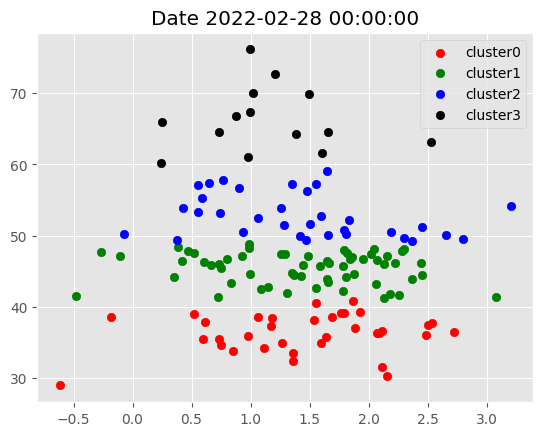

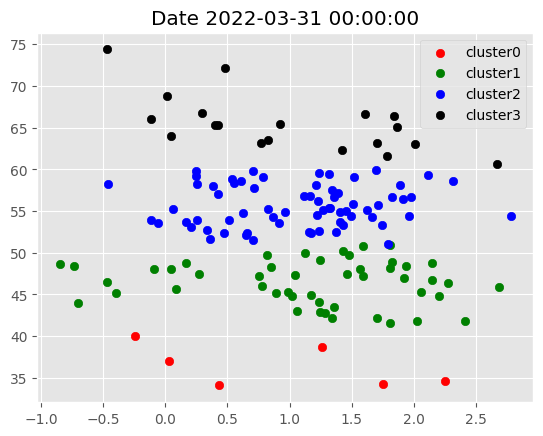

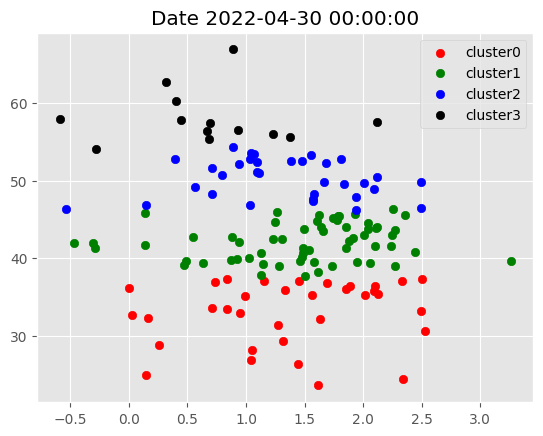

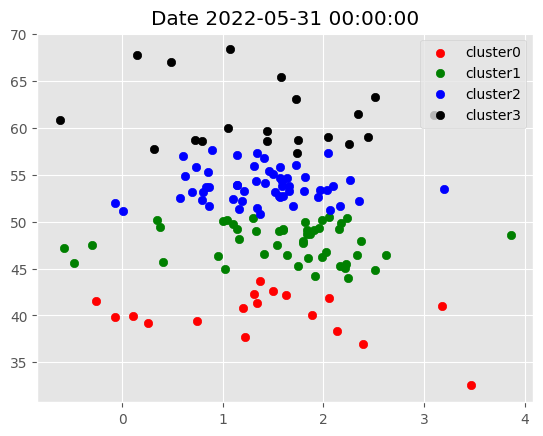

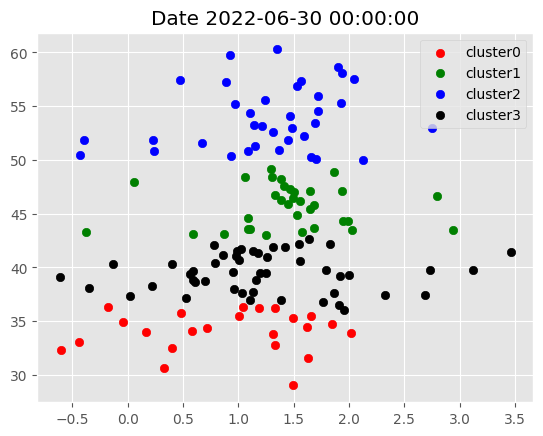

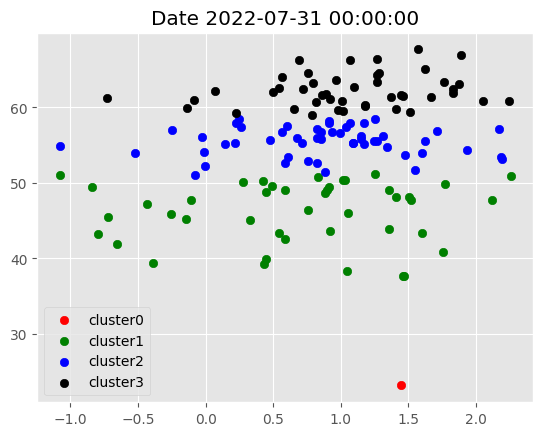

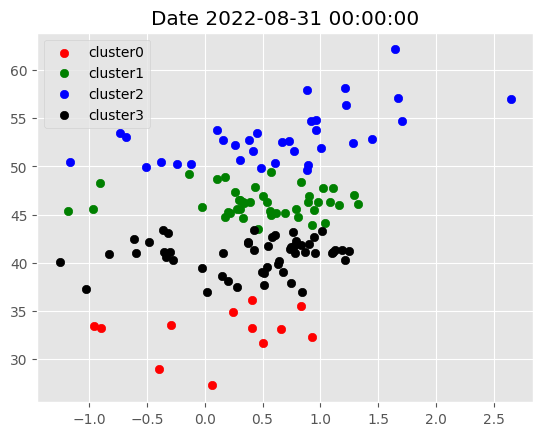

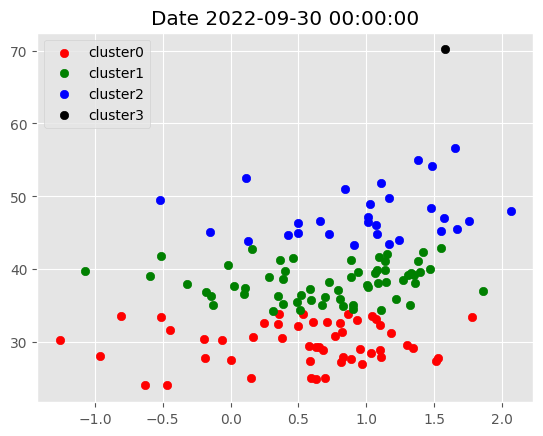

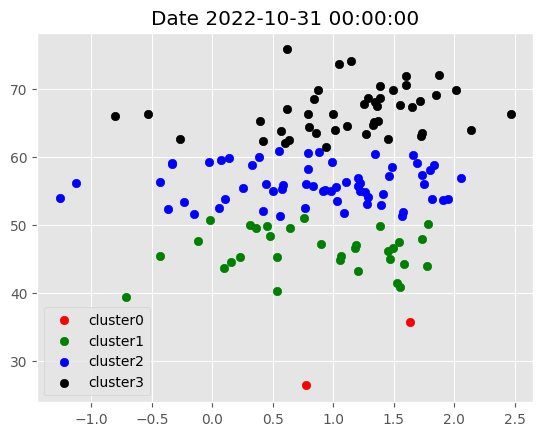

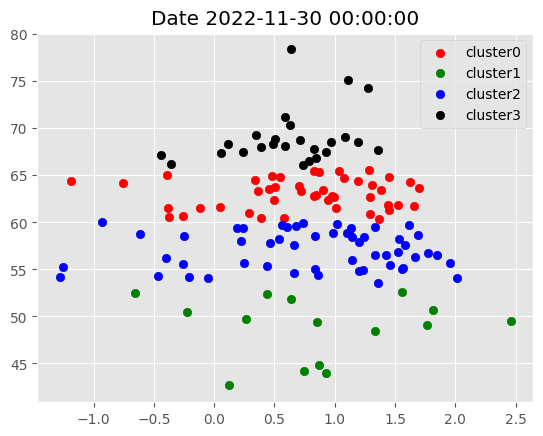

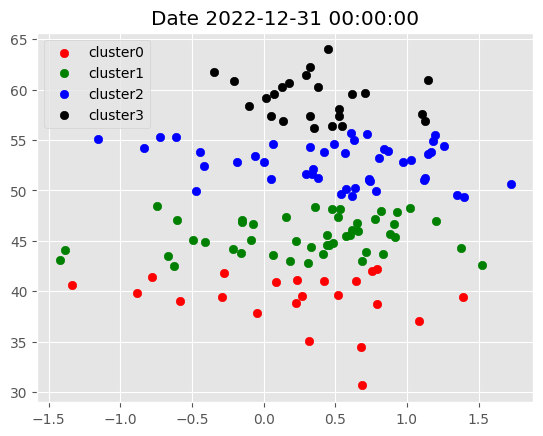

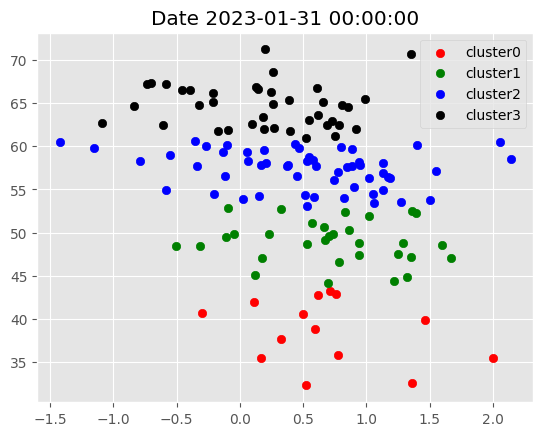

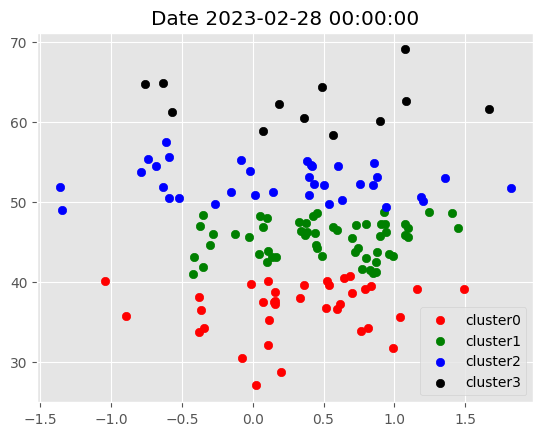

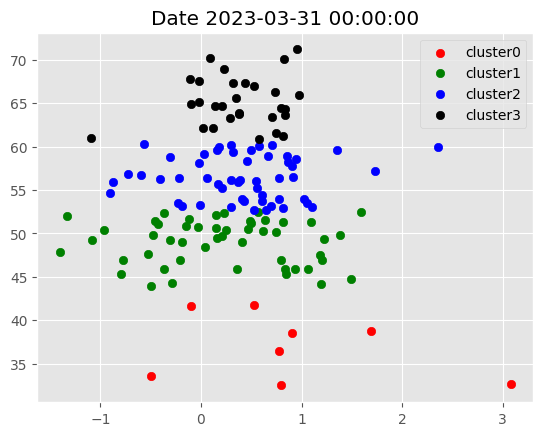

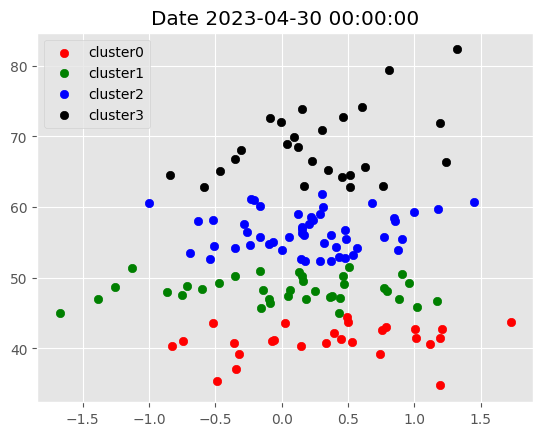

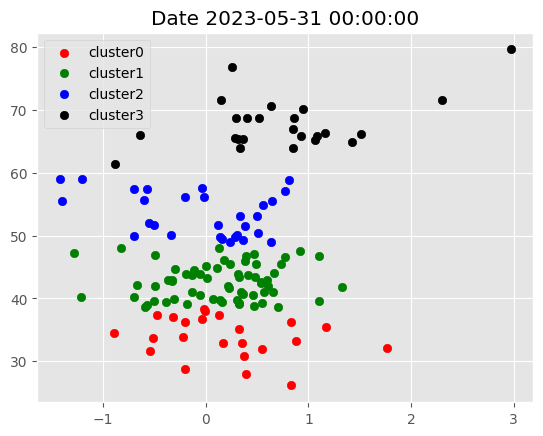

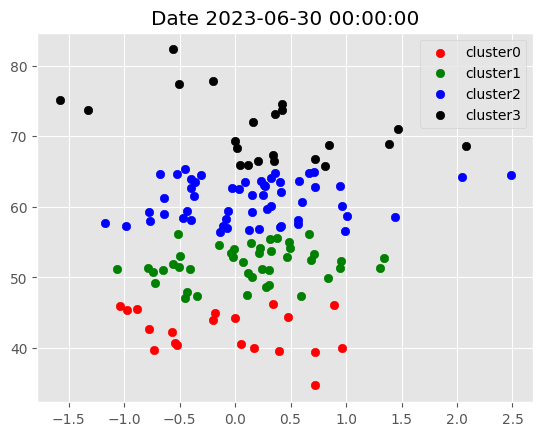

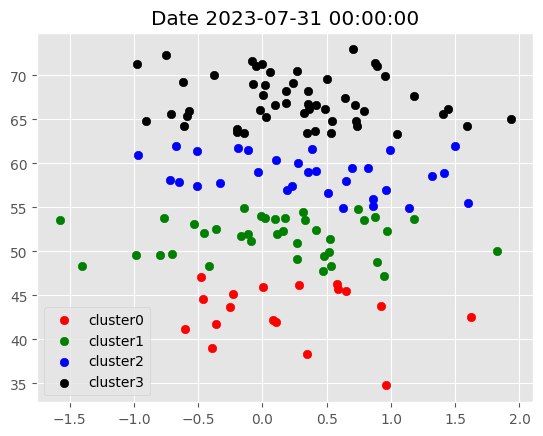

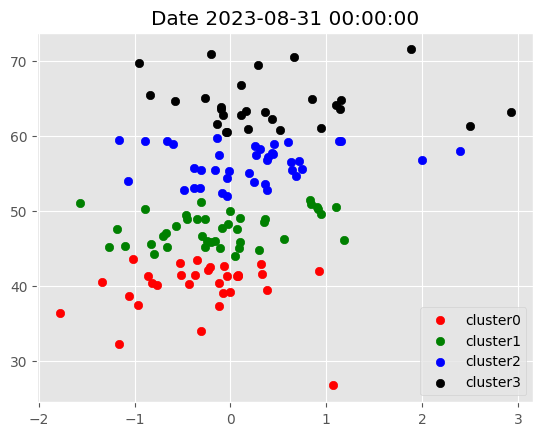

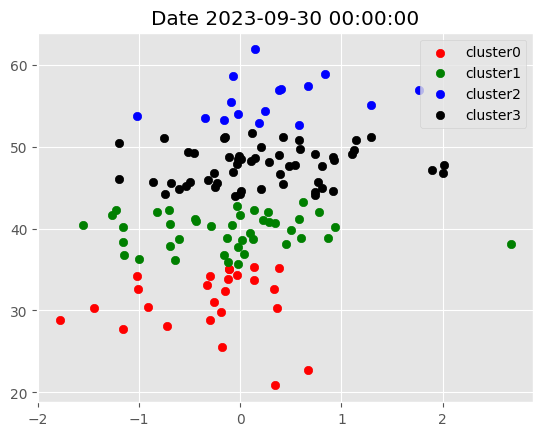

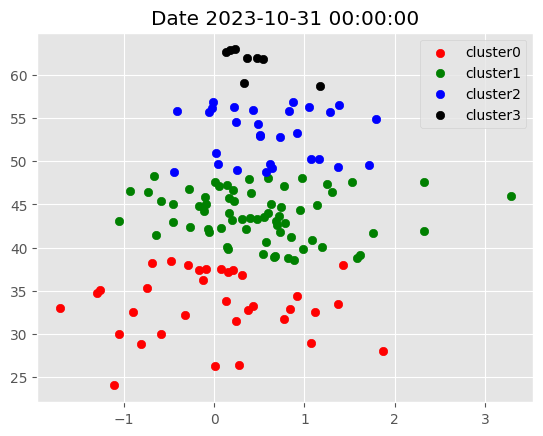

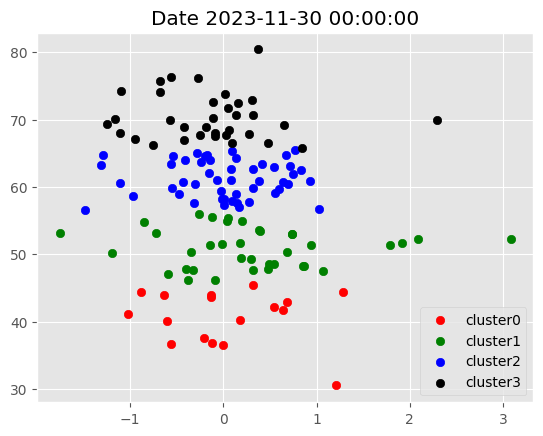

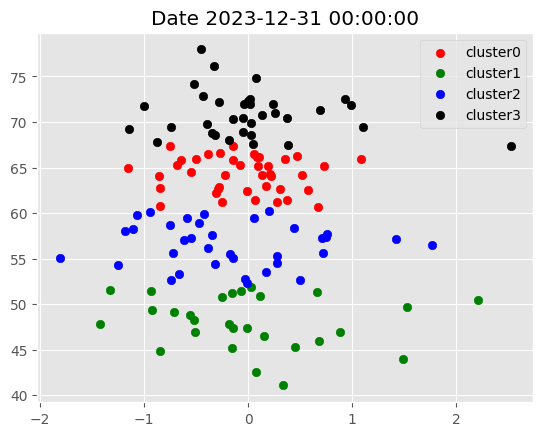

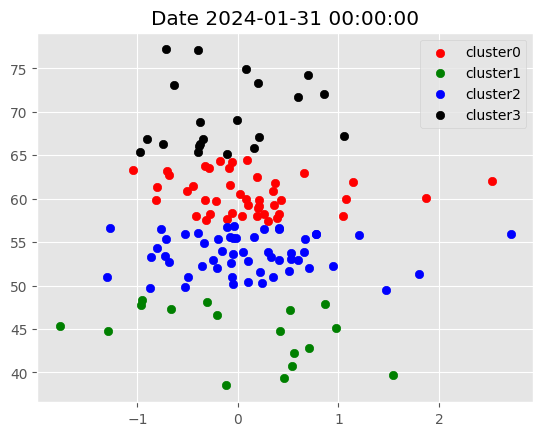

In [34]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [35]:
filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',


## Define portfolio optimization function

- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [36]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

Download Fresh Daily Prices Data only for short listed stocks.

In [37]:
stocks = data.index.get_level_values('symbol').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

[*********************100%%**********************]  156 of 156 completed


In [38]:
new_df

Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-01-31  42.760246   28.233551   44.951492   36.922539  102.222725   
2017-02-01  42.566975   29.955248   44.789665   37.417549  101.630219   
2017-02-02  42.528324   29.904064   44.789665   37.788815  102.016258   
2017-02-03  42.711933   30.032022   44.627831   37.815327  102.779297   
2017-02-06  43.774891   30.313549   44.613117   37.505939  102.501022   
...               ...         ...         ...         ...         ...   
2024-01-08  14.580000  185.559998  159.902237  111.859612  340.350006   
2024-01-09  14.380000  185.139999  160.773911  112.188026  342.750000   
2024-01-10  14.350000  186.190002  163.329498  113.849998  345.329987   
2024-01-11  14.590000  185.589996  162.229996  113.500000  347.970001   
2024-01-12  13.210000  185.919998  162.399994  113.919998  356.329987   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-31  113.379997   87.153656   81.339996  53.358723   31.547512  ...   
2017-02-01  113.360001   82.200096   81.279999  53.367012   32.265957  ...   
2017-02-02  113.160004   83.123482   82.760002  53.242462   32.183064  ...   
2017-02-03  115.169998   83.598137   84.410004  53.923355   32.523880  ...   
2017-02-06  114.459999   83.252937   82.820000  53.890144   32.404121  ...   
...                ...         ...         ...        ...         ...  ...   
2024-01-08  580.549988  236.759995  235.449997  68.220001  151.559998  ...   
2024-01-09  586.200012  235.220001  235.960007  67.830002  151.029999  ...   
2024-01-10  591.030029  235.289993  238.820007  67.589996  149.809998  ...   
2024-01-11  597.489990  235.339996  240.649994  67.290001  151.949997  ...   
2024-01-12  596.539978  235.949997  242.440002  67.500000  151.250000  ...   

              Volume                                                  \
                   V       VLO     VRTX        VZ       WBA      WDC   
Date                                                                   
2017-01-31   7479400  11657700  2418400  16844200   3424400  3617800   
2017-02-01   7534400   5204500  1754700  26004100   5080000  3897800   
2017-02-02  11142300   6193200  1290800  17787200   3667400  2982700   
2017-02-03  28079600   4416400  1226800  15166400   3167700  2624900   
2017-02-06   9665300   4297800  1423800  16151400   3418400  2307400   
...              ...       ...      ...       ...       ...      ...   
2024-01-08   4659000   2756500  1142200  28483000  24038200  3390200   
2024-01-09   7055800   2273300  1106100  17880100  17941700  4799000   
2024-01-10   4355800   2714400  1192400  16354700  15365200  4301900   
2024-01-11   5599000   2388100  1593100  31289800  15428100  3102900   
2024-01-12   4656100   3271000  1183600  18773500  17439100  2819300   

                                                  
                 WFC      WMT     WYNN       XOM  
Date                                              
2017-01-31  22409100  9320900  1827500  19128100  
2017-02-01  21157700  9050000  3025400  15111800  
2017-02-02  13044400  8998700  1698700  12200100  
2017-02-03  19879800  7625300  1888800  12746300  
2017-02-06  13940200  9097200  2828800   9938200  
...              ...      ...      ...       ...  
2024-01-08  15119700  6893600  1441700  23370100  
2024-01-09  13625200  7774100  1803300  19496600  
2024-01-10  11849800  6707300  1683500  18206100  
2024-01-11  21049200  4785100  1871000  15833400  
2024-01-12  30452700  4542600  1913700  18032100  

[1750 rows x 936 columns]

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculate each day portfolio return.

In [52]:
returns_df = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        # optimization_df = new_df['2017-02-01' : '2018-01-31']['Adj Close'][cols]

        success = False
        try: 
            weights = optimize_weights(prices=optimization_df,
                                lower_bound=round(1/(len(optimization_df.columns)*2),3))
        
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        except:
            print(f'Max Sharpe Optimization Failed for {start_date}, continuing with equal-weights')

        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                index=optimization_df.columns.tolist(),
                                columns=pd.Series(0)).T

        temp_df = returns_df[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                                                                                left_index=True,
                                                                                right_index=True).reset_index().set_index(['Date', 'index']).unstack().stack()
        temp_df.index.names = ['date', 'symbol']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('strategy return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    except Exception as e:
        print(e)

Max Sharpe Optimization Failed for 2018-05-01, continuing with equal-weights
Max Sharpe Optimization Failed for 2020-03-01, continuing with equal-weights
Max Sharpe Optimization Failed for 2020-04-01, continuing with equal-weights
Max Sharpe Optimization Failed for 2021-02-01, continuing with equal-weights
Max Sharpe Optimization Failed for 2021-10-01, continuing with equal-weights
Max Sharpe Optimization Failed for 2022-09-01, continuing with equal-weights
Max Sharpe Optimization Failed for 2022-10-01, continuing with equal-weights
Max Sharpe Optimization Failed for 2023-11-01, continuing with equal-weights
'return'


In [53]:
portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

,strategy return
date,
2018-02-01,-0.007097
2018-02-02,-0.017952
2018-02-05,-0.041640
2018-02-06,0.017543
2018-02-07,0.001828
...,...
2024-01-08,0.016386
2024-01-09,0.001334
2024-01-10,0.002065


<Axes: xlabel='date'>

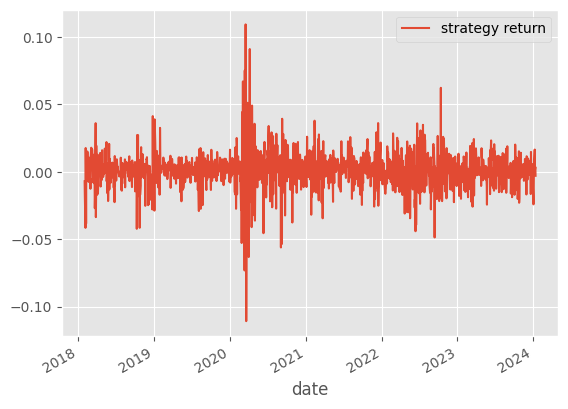

In [56]:
portfolio_df.plot()

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [61]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end = dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close' : 'spy buy&hold'}, axis=1)

[*********************100%%**********************]  1 of 1 completed


,SPY Buy&Hold
Date,
2015-01-05,-0.018225
2015-01-06,-0.009463
2015-01-07,0.012384
2015-01-08,0.017590
2015-01-09,-0.008046
...,...
2024-01-08,0.014175
2024-01-09,-0.001518
2024-01-10,0.005639


In [62]:
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
portfolio_df

,strategy return,SPY Buy&Hold
2018-02-01,-0.007097,-0.001136
2018-02-02,-0.017952,-0.022010
2018-02-05,-0.041640,-0.042722
2018-02-06,0.017543,0.019511
2018-02-07,0.001828,-0.005440
...,...,...
2024-01-08,0.016386,0.014175
2024-01-09,0.001334,-0.001518
2024-01-10,0.002065,0.005639
2024-01-11,0.003494,-0.000441


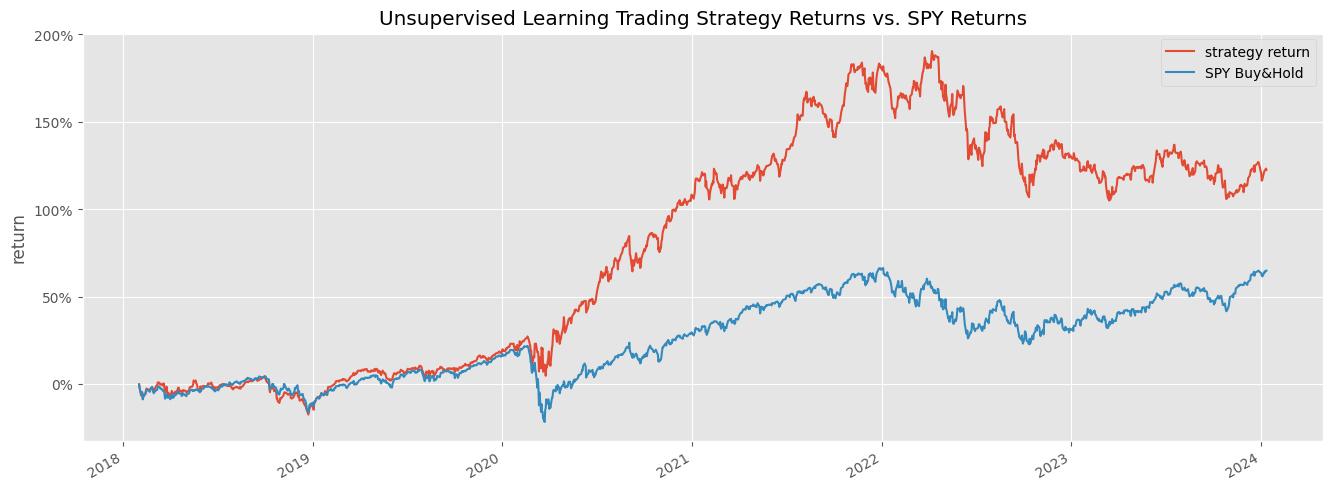

In [66]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return.plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns vs. SPY Returns')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('return')
plt.show()